In [2]:
import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt
import pytorch_lightning as pl
from torch import nn
from torch.nn import functional as F
from torchvision import transforms
from torch.utils.data import DataLoader, random_split
from PIL import Image

In [74]:
class LeNet5(pl.LightningModule):
    def __init__(self, hparams):
        super().__init__()
        self.hparams = hparams
        self.conv = nn.Sequential(
            nn.Conv2d(1, 6, kernel_size=5, stride=1),
            nn.Tanh(),
            nn.AvgPool2d(2, 2),
            nn.Conv2d(6, 16, kernel_size=5, stride=1),
            nn.Tanh(),
            nn.AvgPool2d(2, 2),
            nn.Conv2d(16, 120, kernel_size=5, stride=1),
            nn.Tanh()
        )
        self.linear = nn.Sequential(
            nn.Linear(120, 84),
            nn.Tanh(),
            nn.Linear(84, 10)
        )
        
    def forward(self, x):
        out = self.conv(x)
        out = torch.flatten(out, 1)
        out = self.linear(out)
        
        return out        
        
    def general_step(self, batch, batch_idx):
        image, labels = batch
        out = self.forward(image)
        
        loss = F.cross_entropy(out, labels)
        pred = out.argmax(axis=1)
        acc = (pred == labels).float().mean()
        
        return loss, acc
    
    def training_step(self, batch, batch_idx):
        loss, acc = self.general_step(batch, batch_idx)
        logs = {'train_loss': loss, 'training_acc': acc}
        return {'loss': loss, 'training_acc': acc, 'log': logs}
    
    def validation_step(self, batch, batch_idx):
        loss, acc = self.general_step(batch, batch_idx)
        logs = {'val_loss': loss, 'val_acc': acc}
        return {'val_loss': loss, 'val_acc': acc, 'log': logs}
    
    def test_step(self, batch, batch_idx):
        loss, acc = self.general_step(batch, batch_idx)
        
        logs = {'test_loss': loss, 'test_acc': acc}
        return {'test_loss': loss, 'test_acc': acc, 'log': logs}
    
    def validation_end(self, outputs):
        avg_loss = torch.stack([x['val_loss'] for x in outputs]).mean()
        avg_acc = torch.stack([x['val_acc'] for x in outputs]).mean()
        logs = {'val_loss': avg_loss, 'val_acc': avg_acc}
        return {'val_loss': avg_loss, 'val_acc': avg_acc, 'log': logs}
    
    def test_epoch_end(self, outputs):
        avg_loss = torch.stack([x['test_loss'] for x in outputs]).mean().item()
        avg_acc = torch.stack([x['test_acc'] for x in outputs]).mean().item() * 100
        logs = {'test_loss': avg_loss, 'test_acc': avg_acc}
        test_acc = "{:.2f}".format(avg_acc) + '%'
        print("Test Accuracy:", test_acc)
        return {'test_loss': avg_loss, 'test_acc': avg_acc, 'log': logs}
    
    def prepare_data(self):
        transform = transforms.Compose([transforms.Resize((32, 32)),
                                        transforms.ToTensor(),
                                        transforms.Normalize((0.5), (0.5))])
        
        mnist_train = torchvision.datasets.MNIST(root='./data/', train=True, transform=transform, download=True)
        mnist_test = torchvision.datasets.MNIST(root='./data/', train=False, transform=transform, download=True)
        
        self.train_data, self.val_data = random_split(mnist_train, [50000, 10000])
        self.test_data = mnist_test
        
    def train_dataloader(self):
        return DataLoader(self.train_data, batch_size=self.hparams['batch_size'], shuffle=True)
    
    def val_dataloader(self):
        return DataLoader(self.val_data, batch_size=self.hparams['batch_size'])
    
    def test_dataloader(self):
        return DataLoader(self.test_data)
    
    def configure_optimizers(self):
        opt = torch.optim.SGD(self.parameters(), lr=self.hparams['learning_rate'], momentum=0.9)
        return opt
        
    def predict(self, img, true_label=None):
        self.eval()
        self.cuda()
        transform = transforms.Compose([transforms.Resize((32, 32)),
                                        transforms.ToTensor(),
                                        transforms.Normalize((0.5), (0.5))])
        img = transform(img)
        img_tensor = img.view((1,) + tuple(img.size()))
        pred = self.forward(img_tensor.cuda()).argmax(axis=1)
        
        if true_label:
            print("The number is:", true_label)
        print("Recognized:", pred)
        
        img = img / 2 + 0.5
        npimg = img.numpy().reshape((32, 32))
        plt.imshow(npimg, cmap='gray')
        plt.show()

In [75]:
hparams = {
    "batch_size": 152,
    'learning_rate': 0.07249465638400594
}

In [76]:
model = LeNet5(hparams)

In [23]:
trainer = pl.Trainer(profiler=True, gpus=1, max_epochs=34)
trainer.fit(model)

GPU available: True, used: True
No environment variable for node rank defined. Set as 0.
CUDA_VISIBLE_DEVICES: [0]

   | Name     | Type       | Params
------------------------------------
0  | conv     | Sequential | 50 K  
1  | conv.0   | Conv2d     | 156   
2  | conv.1   | Tanh       | 0     
3  | conv.2   | AvgPool2d  | 0     
4  | conv.3   | Conv2d     | 2 K   
5  | conv.4   | Tanh       | 0     
6  | conv.5   | AvgPool2d  | 0     
7  | conv.6   | Conv2d     | 48 K  
8  | conv.7   | Tanh       | 0     
9  | linear   | Sequential | 11 K  
10 | linear.0 | Linear     | 10 K  
11 | linear.1 | Tanh       | 0     
12 | linear.2 | Linear     | 850   




Profiler Report

Action              	|  Mean duration (s)	|  Total time (s) 
-----------------------------------------------------------------
on_train_start      	|  0.032          	|  0.032          
on_epoch_start      	|  0.00091176     	|  0.031          
get_train_batch     	|  0.026951       	|  302.39         
on_batch_start      	|  1.8237e-05     	|  0.204          
model_forward       	|  0.0027152      	|  30.372         
model_backward      	|  0.0029792      	|  33.325         
on_after_backward   	|  2.7713e-06     	|  0.031          
optimizer_step      	|  0.0018472      	|  20.663         
on_batch_end        	|  0.0015171      	|  16.97          
on_epoch_end        	|  0.0            	|  0.0            
on_train_end        	|  0.0            	|  0.0            



1

In [24]:
trainer.test(model)

Test Accuracy: 98.88%
--------------------------------------------------------------------------------
TEST RESULTS
{'test_acc': 98.87999892234802, 'test_loss': 0.047083690762519836}
--------------------------------------------------------------------------------



In [27]:
%load_ext tensorboard
%tensorboard --logdir lightning_logs

Reusing TensorBoard on port 6006 (pid 3272), started 0:06:40 ago. (Use '!kill 3272' to kill it.)

In [28]:
torch.save(model.state_dict(), './models/len5_model_optimized.pth')

In [77]:
model.load_state_dict(torch.load('./models/len5_model_optimized.pth'))

<All keys matched successfully>

In [99]:
transform = transforms.Compose([transforms.Resize((32, 32)),
                                        transforms.ToTensor(),
                                        transforms.Normalize((0.5), (0.5))])
        
mnist_test = torchvision.datasets.MNIST(root='./data/', train=True, transform=transform, download=True)
test = DataLoader(mnist_test)
sample = iter(test).next()

In [100]:
label = sample[1]
model.cuda()
pred = model.forward(sample[0].cuda()).argmax(axis=1)

In [101]:
pred

tensor([5], device='cuda:0', grad_fn=<NotImplemented>)

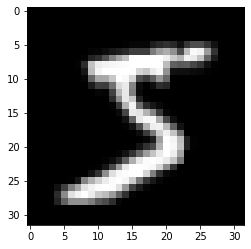

In [102]:
img = sample[0]
img = img / 2 + 0.5
npimg = img.numpy().reshape((32, 32))
plt.imshow(npimg, cmap='gray')
plt.show()

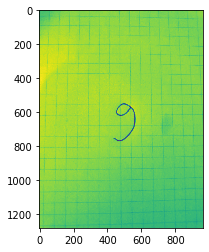

In [111]:
img = Image.open('nine.jpg')
img = img.convert('L')

plt.imshow(np.asarray(img))

The number is: 7
Recognized: tensor([8], device='cuda:0', grad_fn=<NotImplemented>)


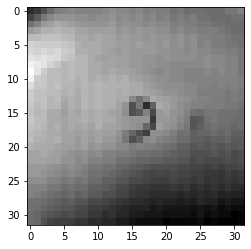

In [112]:
model.predict(img, 7)